In [1]:
# Standard Python modules
import os, sys
import yaml
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc
# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
# Extra 
import wrf

# import personal modules

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap, add_subregion_boxes, make_cmap, add_hasia_labels
import nclcmaps as nclc
from utils import find_perpindicular_line, find_parallel_line, find_intersection_two_lines, add_days_to_date

In [2]:
# Set up paths
server= 'great'
if server == 'great':
    path_to_data = '/home/nash/DATA/data/'
else:
    path_to_data = '/work2/08540/dlnash/frontera/data/'                                      # project data -- read only

path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
# Select lat/lon grid
lonmin = 60.2
lonmax = 100
latmin = 16
latmax = 50

lonmin = 71
lonmax = 77
latmin = 32
latmax = 35

In [4]:
## Get lines and points for mesoscale analysis

# hlat, hlon, tlat, tlon
Line1 = [39.5, 71., 32.25, 81.]
x1, y1, x2, y2 = Line1[3],Line1[2],Line1[1],Line1[0]

# calculate parallel lines
Line2, eq1, eq2 = find_parallel_line(x1, y1, x2, y2, -3., 69.,  80.)
Line3, eq1, eq3 = find_parallel_line(x1, y1, x2, y2, -2., 69.,  80.)

## calculate perpindicular cross section lines
newx_lst = [74.5, 76., 76.25, 78.5]
newx_lst = [74.25, 76.25]
newline = []
ptlst = []
for i, newx in enumerate(newx_lst):
    # get perpindicular line
    line, eq = find_perpindicular_line(x1, y1, x2, y2, newx)
    newline.append(line)
    # get intersecting point for each newline and Line3
    pt = find_intersection_two_lines(eq2[0], eq2[1], eq[0], eq[1])
    ptlst.append(pt)


## Import WRF data

In [5]:
%%time
## above average freezing height, below average freezing height
arname = ['feb1998', 'feb2010']
ar_lst = []
for j, ar in enumerate(arname):
    # import configuration file for case study choice
    yaml_doc = '../data/config_files/ar_casestudy.yml'
    config = yaml.load(open(yaml_doc), Loader=yaml.SafeLoader)
    ar_dict = config[ar]

    year = ar_dict['year']
    month = ar_dict['month']
    start_date = ar_dict['start_date']
    end_date = add_days_to_date(ar_dict['end_date'], 1)
    print(start_date, end_date)
    
    ## Now load data for that AR event
    domains = ['d02', 'd02', 'd01']
    varname_lst = ['prec', 'sr', 'zerodegisotherm']
    res_lst = ['3hr', '3hr', '3hr']


    ## loop through each ds
    ds_lst = []
    for i, (dom, varname, res) in enumerate(zip(domains, varname_lst, res_lst)):
        if server == 'great':
            data_path = path_to_data + 'wrf_hasia/'
        else:
            data_path = path_to_data + 'wrf_preprocessed_data/wrf_6km/'

        if res == 'daily':
            filename_pattern = '{0}/{1}/daily/out.wrf6km.{1}.daily_{2}.nc'.format(dom, varname, year)
        else: 
            filename_pattern = '{0}/{1}/3hr/tmp_{2}.nc'.format(dom, varname, year)

        fname = data_path + filename_pattern
        print(fname)
        ds = xr.open_dataset(fname)

        # subset to just ar days
        ds = ds.sel(time = slice(start_date, end_date))

        if varname == 'ivt':
            ds = ds.assign(ivt=lambda ds: np.sqrt(ds.ivtu**2 + ds.ivtv**2))
        if varname == 'geopotential':
            ds = ds.sel(lev=250.)
        if varname == 'prec':
            # Calculate precipitation rate
            ds = ds.shift(time=-1) - ds # if in xarray
            ## now calculate sum for precipitation for duration of event
            ds = ds.sum('time')
        if varname == 'sr':
        ## now calculate mean frozen fraction for duration of event
            ds = ds.mean('time')
        if varname == 'zerodegisotherm':
        ## now calculate mean zero degree isotherm for duration of event
            ds = ds.mean('time')
            
        ds_lst.append(ds)
    ar_lst.append(ds_lst)

ar_lst[0][0]

1998-02-12 1998-02-16
/home/nash/DATA/data/wrf_hasia/d02/prec/3hr/tmp_1998.nc
/home/nash/DATA/data/wrf_hasia/d02/sr/3hr/tmp_1998.nc
/home/nash/DATA/data/wrf_hasia/d01/zerodegisotherm/3hr/tmp_1998.nc
2010-02-04 2010-02-09
/home/nash/DATA/data/wrf_hasia/d02/prec/3hr/tmp_2010.nc
/home/nash/DATA/data/wrf_hasia/d02/sr/3hr/tmp_2010.nc
/home/nash/DATA/data/wrf_hasia/d01/zerodegisotherm/3hr/tmp_2010.nc
CPU times: user 1.31 s, sys: 1.12 s, total: 2.43 s
Wall time: 4.01 s


<xarray.Dataset>
Dimensions:  (lat: 312, lon: 447)
Coordinates:
  * lat      (lat) float32 22.05 22.11 22.18 22.24 ... 40.17 40.23 40.28 40.33
  * lon      (lon) float32 68.24 68.31 68.37 68.44 ... 98.91 98.98 99.05 99.12
Data variables:
    prec     (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    snowh    (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    snow     (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [6]:
## calculate difference in fraction of frozen precipitation
## below average freezing height - above average freezing height 
prec_diff = ar_lst[0][0].prec.values - ar_lst[1][0].prec.values
sr_diff = ar_lst[0][1].sr.values - ar_lst[1][1].sr.values
zeroiso_diff = ar_lst[0][2].z.values - ar_lst[1][2].z.values

diff_lst = [prec_diff, sr_diff, zeroiso_diff] # put into list for plotting

In [7]:
print('Precipitation contour bounds', np.nanmin(prec_diff), np.nanmax(prec_diff))
print('Fraction of Frozen precip contour bounds', np.nanmin(sr_diff), np.nanmax(sr_diff))
print('Freezing level contour bounds', np.nanmin(zeroiso_diff), np.nanmax(zeroiso_diff))

Precipitation contour bounds -290.41608 169.22754
Fraction of Frozen precip contour bounds -0.9146374 0.45968413
Freezing level contour bounds -1444.8928 1638.2966


### WRF Terrain

In [8]:
wrf_filenames = ar_dict['wrf_files2'] 
wrfin = nc.Dataset(wrf_filenames[0])
terrain = wrf.getvar(wrfin, 'ter', timeidx=0) # get terrain height


In [9]:
# Set seaborn plot style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# Set projections
datacrs = ccrs.PlateCarree()   # data/source
mapcrs = ccrs.PlateCarree()    # map/destination

# extent of maps
ext2 = [lonmin,lonmax,latmin,latmax]
# ext2 = [69.0, 82.0, 30.0, 40.]

# # Set tick/grid locations for d01
# dx = np.arange(round(ext[0], 0),round(ext[1]+10, 0),10)
# dy = np.arange(round(ext[2], 0),round(ext[3]+10, 0),10)

# Set tick/grid locations for d02
dx = np.arange(round(ext2[0], 0),round(ext2[1]+1, 0),1)
dy = np.arange(round(ext2[2], 0),round(ext2[3]+1, 0),1)



In [10]:
# filepath = path_to_figs + 'WRF_prec_summary.png'
# nrows = 6
# ncols = 2

# # point location for (a) (b) (c) label annotation
# xpt = 0.025
# ypt = 0.97

# # Create figure
# fig = plt.figure(figsize=(8,14.))

# ## Use gridspec to set up a plot with a series of subplots that is
# ## n-rows by n-columns
# gs = GridSpec(nrows, ncols, height_ratios=[1, 0.05,  1, 0.05, 1, 0.05], width_ratios = [1, 1], hspace=0.01, wspace=0.03)
# ## use gs[rows index, columns index] to access grids
# # Now, create the gridspec structure, as required

# # data to plot
# prec_lst = [ar_lst[0][0].prec.values, ar_lst[1][0].prec.values]
# sr_lst = [ar_lst[0][1].sr.values, ar_lst[1][1].sr.values]
# diff_lst = [prec_diff, sr_diff]

# ## hack for latitude/longitude labels
# share_right = [False, True]
# share_bottom = [False, True]

# ##########################
# ### Total Event Precip ###
# ##########################
# ttl = ['(a)', '(c)']
# axgr_lst = [0, 2]
# for j, (prec, axgr) in enumerate(zip(prec_lst, axgr_lst)):    
#     ax = fig.add_subplot(gs[axgr, 0], projection=mapcrs)
#     ax = draw_basemap(ax, extent=ext2, xticks=dx2, yticks=dy2, left_lats=False, right_lats=False, 
#                       bottom_lons=True, mask_ocean=False)
    
#     # Contour Filled
#     cf = ax.contourf(lons, lats, prec, transform=datacrs,
#                      levels=np.arange(2, 500, 25), cmap=nclc.cmap('WhiteBlueGreenYellowRed'), alpha=0.9, extend='max')
    
#     # Contour Lines (terrain)
#     terclevs=np.array([1000])
#     terlons = terrain.XLONG.values
#     terlats = terrain.XLAT.values
#     cster = ax.contour(terlons, terlats, terrain.values, terclevs, colors='k', linewidths=1.0,
#                     linestyles='solid', transform=datacrs)
    
#     # add text title
#     ax.text(xpt, ypt, ttl[j], ha='left', va='top', transform=ax.transAxes, fontsize=11., backgroundcolor='white', zorder=101)
    
#     if (j == 1):
#         # add landslide points
#         landslide_pts = [[73.7526, 34.0049], [75.8011, 33.1595], [72.6625, 34.8733]]
#         for i, pt in enumerate(landslide_pts):
#             ax.plot(pt[0], pt[1], alpha=0.7, marker='D', mec='k', mfc='#efa91b', markersize=8, transform=mapcrs)
    
# for i in [1, 3]:
# # Add color bar
#     cbax = fig.add_subplot(gs[i,0]) # colorbar axis
#     cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal', ticklocation = 'bottom')
#     cb.set_label('precipitation (mm event$^{-1}$)', fontsize=11, labelpad=3)

# ##############################
# ### Fraction Frozen Precip ###
# ##############################
# ttl = ['(b)', '(d)']
# clipcmap = cmocean.tools.crop_by_percent(cmo.ice, 30, which='min', N=None)
# for j, (sr, axgr) in enumerate(zip(sr_lst, axgr_lst)):    
#     ax = fig.add_subplot(gs[axgr, 1], projection=mapcrs)
#     ax = draw_basemap(ax, extent=ext2, xticks=dx2, yticks=dy2, left_lats=False, right_lats=True, 
#                       bottom_lons=True, mask_ocean=False)
    
#     # Contour Filled
#     cf = ax.contourf(lons, lats, sr, transform=datacrs,
#                      levels=np.arange(0, 1.05, .05), cmap=clipcmap, alpha=0.9, extend='max')
    
#     # Contour Lines (terrain)
#     terclevs=np.array([1000])
#     terlons = terrain.XLONG.values
#     terlats = terrain.XLAT.values
#     cster = ax.contour(terlons, terlats, terrain.values, terclevs, colors='k', linewidths=1.0,
#                     linestyles='solid', transform=datacrs)
    
#     # add text title
#     ax.text(xpt, ypt, ttl[j], ha='left', va='top', transform=ax.transAxes, fontsize=11., backgroundcolor='white', zorder=101)
    
#     if (j == 0):
#         landslide_pts = [[75.192106, 33.33876], [75.182700, 33.30370], [75.810100, 33.18040], [74.943700, 33.01650], [74.187200, 33.57700]]
#         for i, pt in enumerate(landslide_pts):
#             ax.plot(pt[0], pt[1], alpha=0.7, marker='D', mec='k', mfc='#efa91b', markersize=8, transform=mapcrs)
#     elif (j == 1):
#         # add landslide points
#         landslide_pts = [[73.7526, 34.0049], [75.8011, 33.1595], [72.6625, 34.8733]]
#         for i, pt in enumerate(landslide_pts):
#             ax.plot(pt[0], pt[1], alpha=0.7, marker='D', mec='k', mfc='#efa91b', markersize=8, transform=mapcrs)
# for i in [1, 3]:
# # Add color bar
#     cbax = fig.add_subplot(gs[i,1]) # colorbar axis
#     cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal', ticklocation = 'bottom')
#     cb.set_label('fraction of frozen precipitation (-)', fontsize=11, labelpad=3)

# #########################
# ### Difference Precip ###
# #########################
# ttl = ['(e)', '(f)']
# cflevs_lst = [np.arange(-350, 400, 50) ,np.arange(-0.5, 0.6, .1)]
# cbar_lbl = cbar_lbl = [r'$\Delta$ precipitation (mm event$^{-1}$)', r'$\Delta$ fraction of frozen precipitation (-)']
# for j, diff in enumerate(diff_lst):
#     ax = fig.add_subplot(gs[4, j], projection=mapcrs)
#     ax = draw_basemap(ax, extent=ext2, xticks=dx2, yticks=dy2, left_lats=False, right_lats=share_right[j], 
#                       bottom_lons=True, mask_ocean=False)
    
#     # Contour Filled
#     cf = ax.contourf(lons, lats, diff, transform=datacrs,
#                      levels=cflevs_lst[j], cmap=cmo.delta_r, alpha=0.9, extend='both')
    
#     # Contour Lines (terrain)
#     terclevs=np.array([1000])
#     terlons = terrain.XLONG.values
#     terlats = terrain.XLAT.values
#     cster = ax.contour(terlons, terlats, terrain.values, terclevs, colors='k', linewidths=1.0,
#                     linestyles='solid', transform=datacrs)
    
#     # add text title
#     ax.text(xpt, ypt, ttl[j], ha='left', va='top', transform=ax.transAxes, fontsize=11., backgroundcolor='white', zorder=101)
    
#     # Add color bar
#     cbax = fig.add_subplot(gs[5,j]) # colorbar axis
#     cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal', ticklocation = 'bottom')
#     cb.set_label(cbar_lbl[j], fontsize=11, labelpad=3)

    
# # Save figure
# plt.savefig(filepath, dpi=300, bbox_inches='tight')

# # Show
# plt.show()

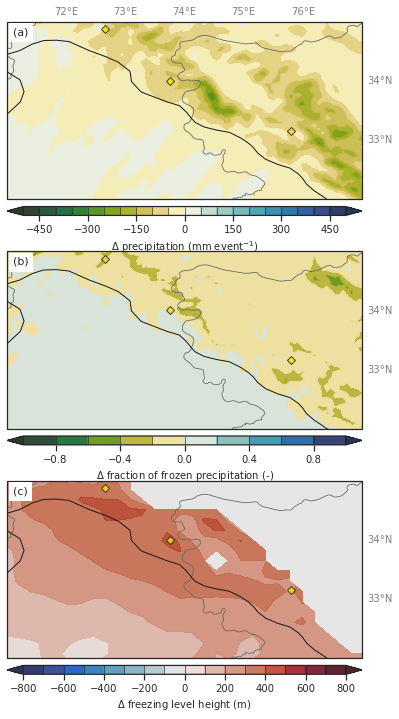

In [15]:
fname = path_to_figs + 'WRF_prec_summary'
fmt = 'png'
nrows = 3
ncols = 1

# point location for (a) (b) (c) label annotation
xpt = 0.015
ypt = 0.97

# hack for tick labels
share_bottom = [False]*2 + [True]
share_top = [True] + [False]*2
# Create figure
fig = plt.figure(figsize=(10,12))
nrows = 3
ncols = 1

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.5,
                cbar_location='bottom', cbar_mode='each',
                cbar_pad=0.1, cbar_size='5%',label_mode='',
                direction='row')

ttl = ['(a)', '(b)', '(c)']
cflevs_lst = [np.arange(-500, 550, 50), np.arange(-1, 1.2, .2), np.arange(-800,900, 100)]
cbar_lbl = cbar_lbl = [r'$\Delta$ precipitation (mm event$^{-1}$)', r'$\Delta$ fraction of frozen precipitation (-)', r'$\Delta$ freezing level height (m)']
cmap_lst = [cmo.delta_r, cmo.delta_r, cmo.balance]
# Loop for drawing each plot
for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=ext2, xticks=dx, yticks=dy,
                      left_lats=False, right_lats=True, bottom_lons=False, top_lons=share_top[k])
    
    lats = ar_lst[0][k].lat.values
    lons = ar_lst[0][k].lon.values
    # Contour Filled
    cf = ax.contourf(lons, lats, diff_lst[k], transform=datacrs,
                     levels=cflevs_lst[k], cmap=cmap_lst[k], alpha=0.9, extend='both')
    
    # Contour Lines (terrain)
    terclevs=np.array([1000])
    terlons = terrain.XLONG.values
    terlats = terrain.XLAT.values
    cster = ax.contour(terlons, terlats, terrain.values, terclevs, colors='k', linewidths=1.0,
                    linestyles='solid', transform=datacrs)
    
    # add landslide points
    # ## 2011 AR
    # landslide_pts = [[75.192106, 33.33876], [75.182700, 33.30370], [75.810100, 33.18040], [74.943700, 33.01650], [74.187200, 33.57700]]
    # for i, pt in enumerate(landslide_pts):
    #     ax.plot(pt[0], pt[1], alpha=0.8, marker='D', mec='k', mfc='#FC8900', markersize=6, transform=mapcrs)
    ## 2010 AR
    landslide_pts = [[73.7526, 34.0049], [75.8011, 33.1595], [72.6625, 34.8733]]
    for i, pt in enumerate(landslide_pts):
        ax.plot(pt[0], pt[1], alpha=0.8, marker='D', mec='k', mfc='#F3E500', markersize=6, transform=mapcrs)
    
    # add text title
    ax.text(xpt, ypt, ttl[k], ha='left', va='top', transform=ax.transAxes, fontsize=11., backgroundcolor='white', zorder=101)
    
    # Colorbar (single)
    cb = fig.colorbar(cf, axgr.cbar_axes[k], orientation='horizontal', drawedges=True)
    cb.set_label(cbar_lbl[k], fontsize=10)
    cb.ax.tick_params(labelsize=10)
    
# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=300)
plt.show()


In [14]:
print(fname)

../figs/WRF_prec_summary.png
